# ADMM

This notebook implements a couple of optimization problems using the [Alternating Direction Method of Multipliers](http://stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf).

As usual **I do not take warranty for the correctness or completeness of this document.**

ADMM is a simple, powerful algorithm for convex optimization particularly suited for applications in machine learning and computational statistics. It can be used to optimize problems of the form:

\begin{align*}
\min \; & \; f(\mathbf{x}) + g(\mathbf{z}) \\
\text{subject to } \; & \; \mathbf{A}\mathbf{x} + \mathbf{B}\mathbf{z} - \mathbf{c} = 0,
\end{align*}

where all variables are real matrices, vectors or scalars. As noted above, we assume the functions $f$ and $g$ to be convex. For details about the stepwise iterations be referred to the review by Boyd *et al.* above.

In [1]:
options(repr.plot.width = 8, repr.plot.height = 3)

## LASSO

We start with the simplest classic: the *LASSO*. The LASSO problem in ADMM form is:

\begin{align*}
\arg \min_{\boldsymbol \beta} & \; f(\boldsymbol \beta) + g(\boldsymbol \beta) \\
 = & \; ||\mathbf{y} - \mathbf{X} \boldsymbol \beta ||^2_2 + \lambda || \boldsymbol \beta ||_1
\end{align*}

We solve the LASSO problem with ADMM using the updates at iteration $i + 1$:

\begin{align*}
\boldsymbol \beta^{i + 1} & \leftarrow \left(\mathbf{X}^T \mathbf{X} + \rho \mathbf{I}\right)^{-1} \left(\mathbf{X}^T \mathbf{y} + \rho(\mathbf{z}^{i} - \mathbf{u}^{i})\right) \\
\mathbf{z}^{i + 1} & \leftarrow s_{\lambda / \rho} \left( \mathbf{x}^{i + 1} + \mathbf{u}^{i} \right) \\
\mathbf{u}^{i + 1} & \leftarrow \mathbf{u}^{i} + \mathbf{x}^{i + 1} - \mathbf{z}^{i + 1},
\end{align*}

where $s$ is the element-wise soft-thresholding operator. Wow, that is suprisingly easy, almost as easy as the CCD.

The LASSO and ADMM of course work for settings where $n \ll p$, but for demonstration we will simulate a simple data set where inference of coefficients is easy. Furthermore, we won't set any regularization parameter, i.e. $\lambda = 0$, such that we can compare our estimate to the least squares estimate. 

We simulate data with $n=1000$ observations and $p=10$ coefficients. In addition, to estimate an intercept, we add a leading one to the design matrix.

In [2]:
n <- 1000
p <- 10
beta <- c(1, rnorm(p))

X <- cbind(1, matrix(rnorm(n * p), n))
y <- X %*% beta + rnorm(n)

In [3]:
lambda <- 0
rho <- 1

For the LASSO, ADMM - just like a CCD - makes use of the same matrices in every iteration. We can pre-compute those once.

In [4]:
Xty <- t(X) %*% y
XtX <- t(X) %*% X
XtX.rho.in <- solve(XtX + rho * diag(p + 1))

In order to get the shrinkage effect, to make use of the soft-thresholding operator again.

In [5]:
soft.threshold <- function(x, thresh)
{
    sign(x) * max(abs(x) - thresh, 0)
}

Then we implement the ADMM for the LASSO. It's ... three lines.

In [6]:
x.step <- z.step <- u.step <- rep(1, p + 1)
for (i in seq(100))
{
    x.step <- XtX.rho.in %*% (Xty + rho*(z.step - u.step))
    z.step <- soft.threshold(x.step +  u.step, lambda / rho)
    u.step <- u.step + x.step - z.step
}

Let's compare ourselves to the OLS.

In [7]:
ols.coefficients <- coef(lm(y ~ 0 + X))

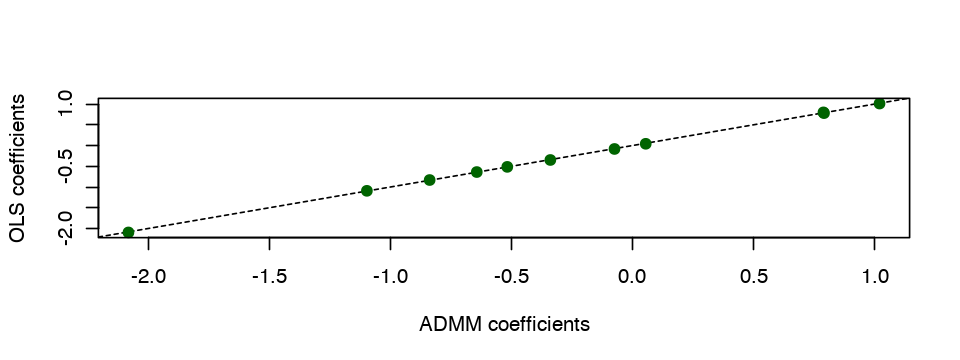

In [8]:
plot(x.step, ols.coefficients, 
     col="darkgreen", pch=19,
     xlab = "ADMM coefficients", ylab="OLS coefficients",    
     panel.first = abline(lm(x.step ~ ols.coefficients), lty=2))